In [1]:
import time
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

X = {}
y = {}

unique_temperatures = np.unique(data['Temp'])

voltage_dict = {}
time_dict = {}
socmin_dict = {}
socmax_dict = {}

for temp in unique_temperatures:
    temp_data = data[data['Temp'] == temp]
    voltage_dict[temp] = temp_data['Voltage'].values
    time_dict[temp] = temp_data['Time'].values
    socmin_dict[temp] = temp_data['SOCmin'].values
    socmax_dict[temp] = temp_data['SOCmax'].values

# print(X)

In [3]:
for temp in unique_temperatures:
    times = time_dict[temp]
    voltages = voltage_dict[temp]
    
    sorted_indices = np.argsort(times)
    times = np.array(times)[sorted_indices]
    voltages = np.array(voltages)[sorted_indices]
    
    unique_times, unique_indices = np.unique(times, return_index=True)
    times = unique_times
    voltages = voltages[unique_indices]

    new_times = []
    for i in range(len(times) - 1):
        new_times.extend(np.linspace(times[i], times[i + 1], 10)[:-1])

    new_times.append(times[-1])  

    cs = CubicSpline(times, voltages)
    interpolated_voltages = cs(new_times)

    time_dict[temp] = new_times
    voltage_dict[temp] = interpolated_voltages
         
total_data_points = sum(len(v) for v in voltage_dict.values())
print(f"Total number of data points: {total_data_points}")

Total number of data points: 5992


In [4]:
temps = []
times = []
socmins = []
socmaxs = []
voltages = []

for temp in sorted(voltage_dict.keys()):
    temps.extend([temp] * len(voltage_dict[temp]))
    times.extend(time_dict[temp])
    socmins.extend([socmin_dict[temp][0]]*len(voltage_dict[temp]))
    socmaxs.extend([socmax_dict[temp][0]]*len(voltage_dict[temp]))
    voltages.extend(voltage_dict[temp])
    
interpolated_data = pd.DataFrame({
    'Temp': temps,
    'Time': times,
    'SOCmin': socmins,
    'SOCmax': socmaxs,
    'Voltage': voltages
})

interpolated_data.to_csv('output.csv', index=False)

for temp in unique_temperatures:
    temp_data = interpolated_data[interpolated_data['Temp'] == temp]
    X[temp] = pd.DataFrame({
        'Time': temp_data['Time'].tolist(),
        'SOCmin': temp_data['SOCmin'].iloc[0],  
        'SOCmax': temp_data['SOCmax'].iloc[0]
    })
    y[temp] = pd.DataFrame({'Voltage': temp_data['Voltage'].tolist()})

print(X[30].head())
print(y[0].head())

       Time     SOCmin     SOCmax
0  0.167616  11.157025  92.355372
1  0.489420  11.157025  92.355372
2  0.811224  11.157025  92.355372
3  1.133028  11.157025  92.355372
4  1.454832  11.157025  92.355372
    Voltage
0  1.656944
1  1.657235
2  1.657532
3  1.657835
4  1.658142


In [5]:
X_train = {}
y_train = {}
X_test = {}
y_test = {}

for temp in unique_temperatures:
    X_train[temp], X_test[temp], y_train[temp], y_test[temp] = train_test_split(X[temp], y[temp], test_size=0.2, random_state=42)
    
print(X_train[0].head())
print(y_train[0].head())

          Time     SOCmin     SOCmax
344  75.120297  25.413223  86.570248
439  75.195512  25.413223  86.570248
234  75.045321  25.413223  86.570248
338  75.116140  25.413223  86.570248
311  75.097197  25.413223  86.570248
      Voltage
344  1.567747
439  1.422531
234  1.712500
338  1.575772
311  1.612346


In [6]:
def_vol = 1.620898947
def_time = 10.12196356
def_socmin = 46.90082645
def_socmax = 85.33057851
def_temp = -10

In [7]:
T0 = -10
T1 = 50
t0 = 10.12196356
socmin = 46.90082645
socmax = 85.33057851

-----------------------------------------------------------------------------------
Performance Metrics for temperature -10:
Mean Squared Error (MSE): 0.0295
Mean Absolute Error (MAE): 0.1297
R-squared (R²): 0.4356
Root Mean Squared Error (RMSE): 0.1716
Prediction Time: 0.0008 seconds
Linear Regression Predicted voltage for temperature = -10 and time = 10.12196356 : 1.7665306115188297 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 0:
Mean Squared Error (MSE): 0.0201
Mean Absolute Error (MAE): 0.1168
R-squared (R²): 0.6385
Root Mean Squared Error (RMSE): 0.1418
Prediction Time: 0.0005 seconds
Linear Regression Predicted voltage for temperature = -10 and time = 10.12196356 : 1.8449978263882683 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 10:
Mean Squared Error (MSE): 0.0409
Mean Absolute Error (MAE): 0.1381
R-squared (R²): 0.3885
Root Mea

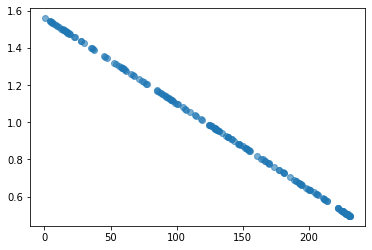

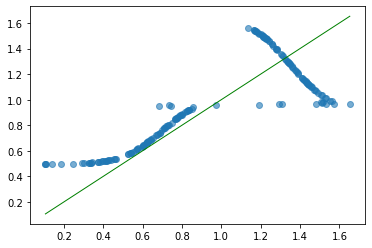

In [8]:
y_pred = {}
lin_model = LinearRegression()
maxr2 = 0
maxr2temp = -100
for temp in unique_temperatures:
    lin_model.fit(X_train[temp], y_train[temp].values.ravel())
    t1 = time.time()
    y_pred[temp] = lin_model.predict(X_test[temp])
    pred_time = time.time() - t1

    mse = mean_squared_error(y_test[temp], y_pred[temp])
    mae = mean_absolute_error(y_test[temp], y_pred[temp])
    r2 = r2_score(y_test[temp], y_pred[temp])
    rmse = np.sqrt(mse)
    
    if r2 > maxr2:
        maxr2 = r2
        maxr2temp = temp
    
    print("-----------------------------------------------------------------------------------")
    print(f"Performance Metrics for temperature {temp}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Prediction Time: {pred_time:.4f} seconds")

    volt_pred = lin_model.predict([[t0, socmin, socmax]])[0]

    print("Linear Regression Predicted voltage for temperature =", T0, "and time =", t0, ":", volt_pred, "V")    
    

print("-----------------------------------------------------------------------------------")

print("Temperature at max R2: ", maxr2temp)

plt.figure()
plt.scatter(X_test[maxr2temp]['Time'], y_pred[maxr2temp], label=f'Temperature: {maxr2temp}', alpha=0.6)

plt.figure()
plt.scatter(y_test[maxr2temp], y_pred[maxr2temp], alpha=0.6)
min_val = min(y_test[maxr2temp].values.min(), y_pred[maxr2temp].min())
max_val = max(y_test[maxr2temp].values.max(), y_pred[maxr2temp].max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', linewidth=1, label='x = y')

-----------------------------------------------------------------------------------
Performance metrics for temperature -10: 
Mean Squared Error (MSE): 0.0256
Mean Absolute Error (MAE): 0.1367
R-squared (R²): 0.5093
Root Mean Squared Error (RMSE): 0.1600
Prediction Time: 0.0032 seconds
SVM Predicted voltage for temperature = -10 and time = 10.12196356 : 1.50220183524997 V
-----------------------------------------------------------------------------------
Performance metrics for temperature 0: 
Mean Squared Error (MSE): 0.0072
Mean Absolute Error (MAE): 0.0784
R-squared (R²): 0.8701
Root Mean Squared Error (RMSE): 0.0850
Prediction Time: 0.0034 seconds
SVM Predicted voltage for temperature = 0 and time = 10.12196356 : 1.4489240095196767 V
-----------------------------------------------------------------------------------
Performance metrics for temperature 10: 
Mean Squared Error (MSE): 0.0087
Mean Absolute Error (MAE): 0.0830
R-squared (R²): 0.8694
Root Mean Squared Error (RMSE): 0.093

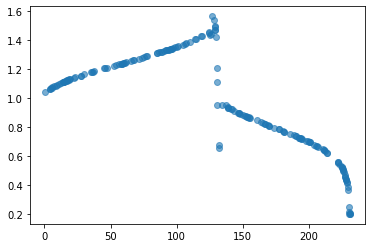

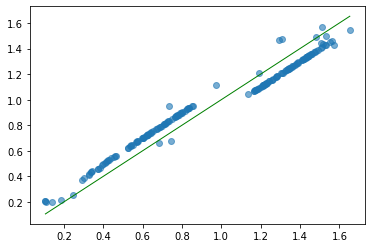

In [9]:
svr_y_pred = {}
svr_model = SVR( kernel='rbf', C=1.0, gamma='auto' )
maxr2 = 0
maxr2temp = -100
for temp in unique_temperatures:
    svr_model.fit(X_train[temp], y_train[temp].values.ravel())

    t1 = time.time()
    svr_y_pred[temp] = svr_model.predict(X_test[temp])
    pred_time = time.time() - t1

    mse = mean_squared_error(y_test[temp], svr_y_pred[temp])
    mae = mean_absolute_error(y_test[temp], svr_y_pred[temp])
    r2 = r2_score(y_test[temp], svr_y_pred[temp])
    rmse = np.sqrt(mse)
    
    if r2 > maxr2:
        maxr2 = r2
        maxr2temp = temp

    print("-----------------------------------------------------------------------------------")
    print(f"Performance metrics for temperature {temp}: ")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Prediction Time: {pred_time:.4f} seconds")

    volt_pred = svr_model.predict([[t0, socmin, socmax]])[0]

    print("SVM Predicted voltage for temperature =", temp, "and time =", t0, ":", volt_pred, "V")
    
print("-----------------------------------------------------------------------------------")

print("Temperature at max R2: ", maxr2temp)

plt.figure()
plt.scatter(X_test[maxr2temp]['Time'], svr_y_pred[maxr2temp], alpha=0.6)

plt.figure()
plt.scatter(y_test[maxr2temp], svr_y_pred[maxr2temp], alpha=0.6)
min_val = min(y_test[maxr2temp].values.min(), svr_y_pred[maxr2temp].min())
max_val = max(y_test[maxr2temp].values.max(), svr_y_pred[maxr2temp].max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', linewidth=1, label='x = y')

-----------------------------------------------------------------------------------
Performance Metrics for temperature -10:
Mean Squared Error (MSE): 0.0012
Mean Absolute Error (MAE): 0.0125
R-squared (R²): 0.9775
Root Mean Squared Error (RMSE): 0.0343
Training Time: 0.0046 seconds
Prediction Time: 0.0007 seconds
Number of Nodes: 921
Tree Depth: 16
Decision Tree Predicted voltage for temperature = -10 and time = 10.12196356 : 1.6208194448222317 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 0:
Mean Squared Error (MSE): 0.0004
Mean Absolute Error (MAE): 0.0052
R-squared (R²): 0.9920
Root Mean Squared Error (RMSE): 0.0211
Training Time: 0.0019 seconds
Prediction Time: 0.0007 seconds
Number of Nodes: 1223
Tree Depth: 18
Decision Tree Predicted voltage for temperature = 0 and time = 10.12196356 : 1.6682805775138387 V
-----------------------------------------------------------------------------------
Performance Met

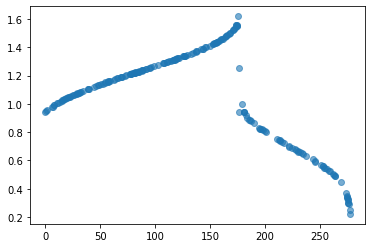

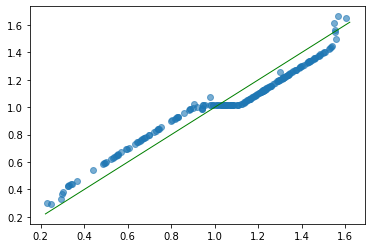

In [10]:
tree_y_pred = {}
treemodel = DecisionTreeRegressor(random_state=0)
maxr2 = 0
maxr2temp = -100

for temp in unique_temperatures:
    t1 = time.time()
    treemodel.fit(X_train[temp], y_train[temp].values.ravel())
    train_time = time.time() - t1

    t2 = time.time()
    tree_y_pred[temp] = treemodel.predict(X_test[temp])
    pred_time = time.time() - t2

    mse = mean_squared_error(y_test[temp], tree_y_pred[temp])
    mae = mean_absolute_error(y_test[temp], tree_y_pred[temp])
    r2 = r2_score(y_test[temp], tree_y_pred[temp])
    rmse = np.sqrt(mse)
    
    if (r2 > maxr2):
        maxr2 = r2
        maxr2temp = temp

    num_nodes = treemodel.tree_.node_count
    tree_depth = treemodel.tree_.max_depth

    print("-----------------------------------------------------------------------------------")
    print(f"Performance Metrics for temperature {temp}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {pred_time:.4f} seconds")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Tree Depth: {tree_depth}")

    tree_volt_pred = treemodel.predict([[t0, socmin, socmax]])[0]

    print("Decision Tree Predicted voltage for temperature =", temp, "and time =", t0, ":", tree_volt_pred, "V")

print("-----------------------------------------------------------------------------------")

print("Temperature at Max R2: ", maxr2temp)

plt.figure()
plt.scatter(X_test[maxr2temp]['Time'], tree_y_pred[maxr2temp], alpha=0.6)

plt.figure()
plt.scatter(y_test[maxr2temp], svr_y_pred[maxr2temp], alpha=0.6)
min_val = min(y_test[maxr2temp].values.min(), tree_y_pred[maxr2temp].min())
max_val = max(y_test[maxr2temp].values.max(), tree_y_pred[maxr2temp].max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', linewidth=1, label='x = y')

-----------------------------------------------------------------------------------
Performance Metrics for temperature -10:
Mean Squared Error (MSE): 0.0007
Mean Absolute Error (MAE): 0.0095
R-squared (R²): 0.9868
Root Mean Squared Error (RMSE): 0.0262
Training Time: 0.0887 seconds
Prediction Time: 0.0061 seconds
Number of Trees (Iterations): 100
Random Forest Predicted voltage for temperature = -10 and time = 10.12196356 : 1.6208231951177314 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 0:
Mean Squared Error (MSE): 0.0001
Mean Absolute Error (MAE): 0.0031
R-squared (R²): 0.9973
Root Mean Squared Error (RMSE): 0.0122
Training Time: 0.0955 seconds
Prediction Time: 0.0065 seconds
Number of Trees (Iterations): 100
Random Forest Predicted voltage for temperature = 0 and time = 10.12196356 : 1.6688515510585267 V
-----------------------------------------------------------------------------------
Performance Metrics 

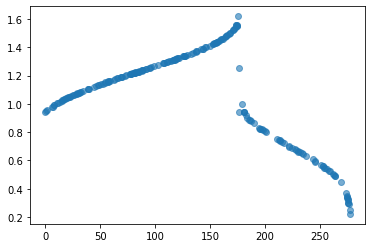

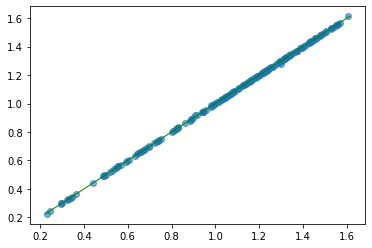

In [11]:
random_y_pred = {}
randommodel = RandomForestRegressor( n_estimators=100, random_state=0 )
maxr2 = 0
maxr2temp = -100

for temp in unique_temperatures:
    t1 = time.time()
    randommodel.fit(X_train[temp], y_train[temp].values.ravel())
    train_time = time.time() - t1

    t2 = time.time()
    random_y_pred[temp] = randommodel.predict(X_test[temp])
    pred_time = time.time() - t2

    mse = mean_squared_error(y_test[temp], random_y_pred[temp])
    mae = mean_absolute_error(y_test[temp], random_y_pred[temp])
    r2 = r2_score(y_test[temp], random_y_pred[temp])
    rmse = np.sqrt(mse)
    
    if (r2 > maxr2):
        maxr2 = r2
        maxr2temp = temp
        
    
    print("-----------------------------------------------------------------------------------")

    print(f"Performance Metrics for temperature {temp}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Training Time: {train_time:.4f} seconds")
    print(f"Prediction Time: {pred_time:.4f} seconds")
    print(f"Number of Trees (Iterations): {randommodel.n_estimators}")

    random_volt_pred = randommodel.predict([[t0, socmin, socmax]])[0]

    print("Random Forest Predicted voltage for temperature =", temp, "and time =", t0, ":", random_volt_pred, "V")
    
print("-----------------------------------------------------------------------------------")

print("Temperature at Max R2: ", maxr2temp)

plt.figure()
plt.scatter(X_test[maxr2temp]['Time'], tree_y_pred[maxr2temp], alpha=0.6)

plt.figure()
plt.scatter(y_test[maxr2temp], random_y_pred[maxr2temp], alpha=0.6)
min_val = min(y_test[maxr2temp].values.min(), random_y_pred[maxr2temp].min())
max_val = max(y_test[maxr2temp].values.max(), random_y_pred[maxr2temp].max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', linewidth=1, label='x = y')

-----------------------------------------------------------------------------------
Performance Metrics for temperature -10:
Mean Squared Error (MSE): 0.0194
Mean Absolute Error (MAE): 0.0885
R-squared (R²): 0.6277
Root Mean Squared Error (RMSE): 0.1394
Prediction Time: 0.0012 seconds
Gradient Boosting Predicted voltage for temperature = -10 and time = 10.12196356 : 1.6342282635024574 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 0:
Mean Squared Error (MSE): 0.0020
Mean Absolute Error (MAE): 0.0194
R-squared (R²): 0.9647
Root Mean Squared Error (RMSE): 0.0443
Prediction Time: 0.0006 seconds
Gradient Boosting Predicted voltage for temperature = 0 and time = 10.12196356 : 1.6949420512039435 V
-----------------------------------------------------------------------------------
Performance Metrics for temperature 10:
Mean Squared Error (MSE): 0.0164
Mean Absolute Error (MAE): 0.0417
R-squared (R²): 0.7540
Root Mean 

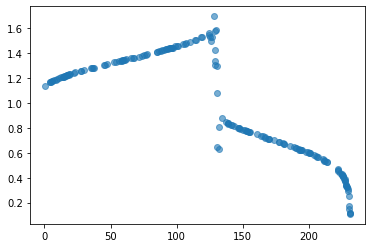

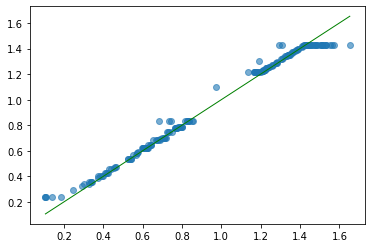

In [12]:
grad_y_pred = {}
gradmodel = GradientBoostingRegressor( n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls' )
maxr2 = 0
maxr2temp = -100

for temp in unique_temperatures:
    gradmodel.fit(X_train[temp], y_train[temp].values.ravel())

    t1 = time.time()
    grad_y_pred[temp] = gradmodel.predict(X_test[temp])
    pred_time = time.time() - t1

    mse = mean_squared_error(y_test[temp], grad_y_pred[temp])
    mae = mean_absolute_error(y_test[temp], grad_y_pred[temp])
    r2 = r2_score(y_test[temp], grad_y_pred[temp])
    rmse = np.sqrt(mse)
    
    if (r2 > maxr2):
        maxr2 = r2
        maxr2temp = temp
    
    print("-----------------------------------------------------------------------------------")
    print(f"Performance Metrics for temperature {temp}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Prediction Time: {pred_time:.4f} seconds")

    grad_volt_pred = gradmodel.predict([[t0, socmin, socmax]])[0]

    print("Gradient Boosting Predicted voltage for temperature =", temp, "and time =", t0, ":", grad_volt_pred, "V")
    
print("-----------------------------------------------------------------------------------")

print("Temp at Max R2: ", maxr2temp)

plt.figure()
plt.scatter(X_test[maxr2temp]['Time'], tree_y_pred[maxr2temp], alpha=0.6)

plt.figure()
plt.scatter(y_test[maxr2temp], grad_y_pred[maxr2temp], alpha=0.6)
min_val = min(y_test[maxr2temp].values.min(), grad_y_pred[maxr2temp].min())
max_val = max(y_test[maxr2temp].values.max(), grad_y_pred[maxr2temp].max())
plt.plot([min_val, max_val], [min_val, max_val], 'g-', linewidth=1, label='x = y')